<a href="https://colab.research.google.com/github/jntanner83/Farmbot/blob/main/Custom_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [ ]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt


In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [ ]:
train_path= "C:/Users/jntan/OneDrive/Documents/Farmbot_MSDS_453/train"
test_path= "C:/Users/jntan/OneDrive/Documents/Farmbot_MSDS_453/test"

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [ ]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
print(classes)

['bacterial_blight', 'cercospora_leaf_blight', 'downey_mildew', 'frogeye', 'healthy', 'potassium_deficiency', 'soybean_rust', 'target_spot']


In [ ]:
# Plot the distribution of images in each class
plt.figure(figsize=(10, 5))
plt.bar(classes, class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.xticks(rotation=45)
plt.show()

# Display two example images from each class
fig, axes = plt.subplots(len(classes), 2, figsize=(10, 5*len(classes)))
for i, class_name in enumerate(classes):
    class_dir = root / class_name
    image_files = list(class_dir.glob('*'))[:2]  # Get the first two image files
    for j, image_file in enumerate(image_files):
        image = plt.imread(str(image_file))
        axes[i, j].imshow(image)
        axes[i, j].set_title(f'{class_name} - Example {j+1}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#CNN Network
class ConvNet(nn.Module):
    def __init__(self,num_classes=8):
        super(ConvNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (256,3,150,150)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)


        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)



        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)


        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)



        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)


            #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)


        output=self.fc(output)

        return output


In [ ]:
model=ConvNet(num_classes=8).to(device)

In [ ]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [ ]:
num_epochs=10

In [ ]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

print(train_count,test_count)

4680 1567


In [ ]:
if next(model.parameters()).is_cuda:
    print("Model is running on GPU")
else:
    print("Model is running on CPU")

Model is running on GPU


In [ ]:
import matplotlib.pyplot as plt

# Lists to store the loss and accuracy values for each epoch
train_losses = []
train_accuracies = []
test_accuracies = []

# Model training and saving best model
best_accuracy = 0.0

for epoch in range(num_epochs):
    # Evaluation and training on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    # Store the train loss and accuracy for each epoch
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy)

    # Evaluation on testing dataset
    with torch.no_grad():
        model.eval()
        test_accuracy = 0.0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, prediction = torch.max(outputs, 1)
            test_accuracy += int(torch.sum(prediction == labels))

    test_accuracy = test_accuracy / test_count

    # Store the test accuracy for each epoch
    test_accuracies.append(test_accuracy)

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) + ' Train Accuracy: ' + str(train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))

    # Save the best model
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy

# Plot the training loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Plot the training and testing accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

Epoch: 0 Train Loss: tensor(0.2965) Train Accuracy: 0.9423076923076923 Test Accuracy: 0.587747287811104
Epoch: 1 Train Loss: tensor(0.1944) Train Accuracy: 0.95491452991453 Test Accuracy: 0.6279514996809189
Epoch: 2 Train Loss: tensor(0.1396) Train Accuracy: 0.9651709401709402 Test Accuracy: 0.583918315252074
Epoch: 3 Train Loss: tensor(0.1352) Train Accuracy: 0.9658119658119658 Test Accuracy: 0.6400765794511806
Epoch: 4 Train Loss: tensor(0.0581) Train Accuracy: 0.985897435897436 Test Accuracy: 0.6368857689853222
Epoch: 5 Train Loss: tensor(0.1345) Train Accuracy: 0.9664529914529915 Test Accuracy: 0.6151882578174857


In [ ]:
# Save the visualization as a PNG image
model_viz.render("model_architecture", format="png")

'model_architecture.png'

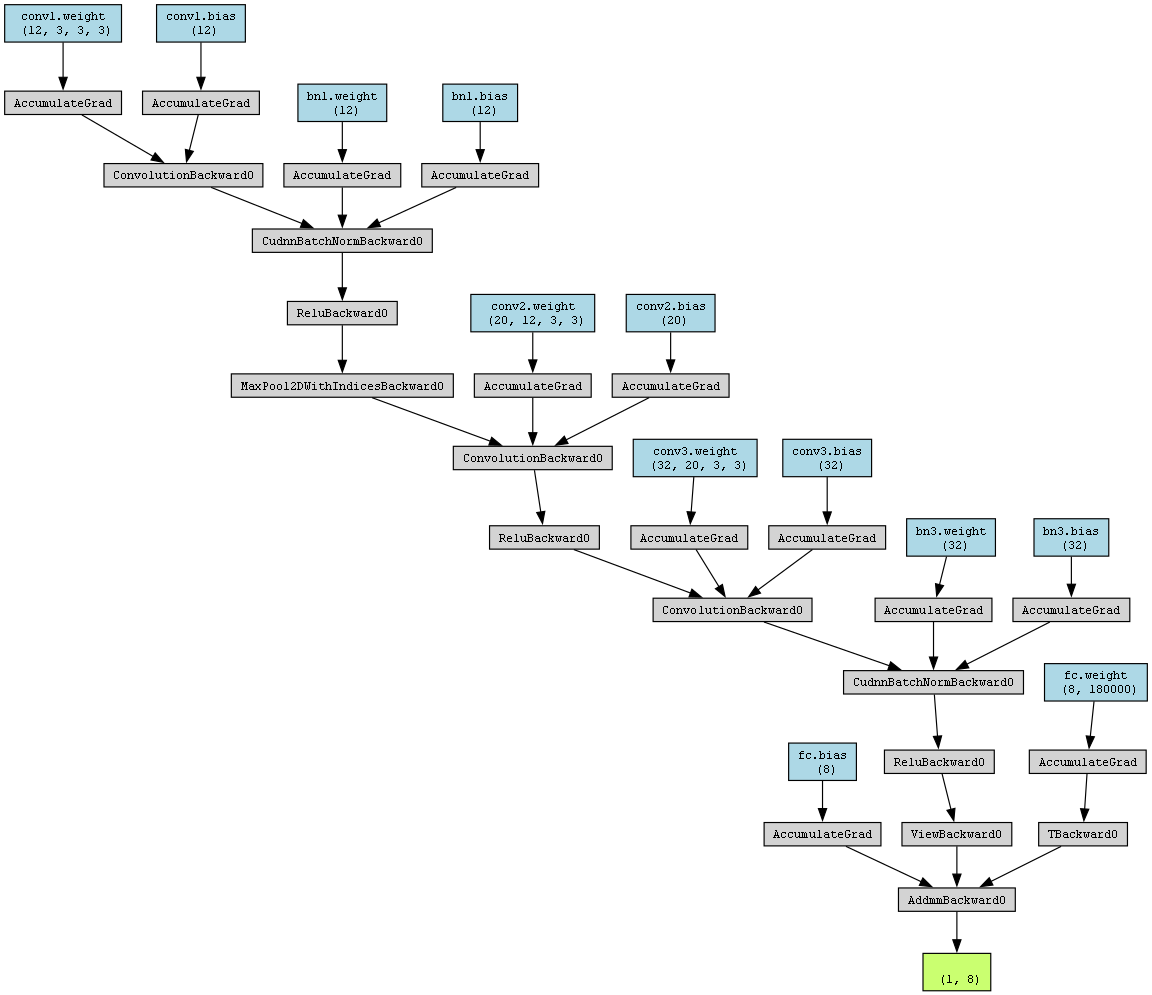

In [ ]:
display.Image("model_architecture.png")

In [ ]:
import matplotlib.pyplot as plt

# Extract the epoch numbers and accuracies from the provided information
epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_accuracies = [0.5465811965811965, 0.6561965811965812, 0.7418803418803419, 0.7818376068376068, 0.8314102564102565,
                    0.836965811965812, 0.8771367521367521, 0.9091880341880342, 0.8893162393162393, 0.9294871794871795]
test_accuracies = [0.40331844288449265, 0.5149968091895342, 0.5137204850031908, 0.5188257817485641, 0.6100829610721124,
                   0.4473516273133376, 0.568602425015954, 0.4913848117421825, 0.4416081684747926, 0.553286534779834]

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the training and test accuracies
ax.plot(epochs, train_accuracies, marker='o', label='Training Accuracy')
ax.plot(epochs, test_accuracies, marker='o', label='Test Accuracy')

# Set the title and labels for the graph
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Add a legend
ax.legend()

# Display the graph
plt.tight_layout()
plt.show()